In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gymnasium as gym
import numpy as np
from tqdm.auto import tqdm
from collections import deque
import pandas as pd
import matplotlib.animation
import matplotlib.pyplot as plt
from pathlib import Path

# Configurações do Matplotlib
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml')

# Verificar se a GPU está disponível e definir o dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


In [16]:
N_EPISODES = 6000
MAX_STEPS = 20000
BATCH_SIZE = 16
DISCOUNT_FACTOR = 0.90
LEARNING_RATE = 1e-4
ENVIRONMENT = "CartPole-v1"

In [17]:
IMAGES_PATH = Path() / "images" / "rl"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [18]:
env = gym.make(ENVIRONMENT, render_mode="rgb_array")

### DQN 

DQN é um algoritmo que combina Q-learning com redes neurais profundas para permitir que um agente aprenda a tomar decisões ótimas em ambientes complexos e de alta dimensão 

Pelo fundamento do Q-learning sendo do objetivo sendo aprender uma gunção de valor $Q(s,a)$, que estima a recompensa total futura ao tomar a ação a no estado S por uma tabela Q-table 

### Pilares fundamentais 

3. Pilar 1: Replay de Experiência (Experience Replay)

Para evitar instabilidade no treino, o DQN não aprende apenas com a última experiência.

- Como funciona: O agente armazena suas experiências $(s,a,r,s′)$ em uma memória. Durante o treino, amostras aleatórias (mini-lotes) são retiradas dessa memória para atualizar a rede.

- Por que é importante: Quebra a correlação entre amostras sequenciais, tornando o aprendizado mais estável e eficiente.

4. Pilar 2: Redes Alvo (Target Networks)

Treinar uma rede usando alvos que ela mesma gera cria um "alvo móvel", causando instabilidade.

- Como funciona: O DQN usa duas redes. A Rede Principal é treinada a todo momento, enquanto a Rede Alvo (uma cópia da principal) é usada para calcular o valor de referência e tem seus pesos atualizados com menos frequência.

Por que é importante: Mantém o alvo de treinamento estável por mais tempo, permitindo que a rede principal convirja de forma mais segura. A função de perda (loss) minimiza a diferença entre a previsão da rede principal e o alvo gerado pela rede alvo.

In [19]:
class DQN(nn.Module):
    def __init__(self, input_shape, n_outputs):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_shape[0], 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, n_outputs)

    def forward(self, x):
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        return self.fc3(x)

input_shape = env.observation_space.shape
n_outputs = env.action_space.n

# Modelo principal e alvo
model = DQN(input_shape, n_outputs).to(device)
target_model = DQN(input_shape, n_outputs).to(device)
target_model.load_state_dict(model.state_dict())
target_model.eval()

print(model)

DQN(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)


In [20]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = model(state_tensor)
        return q_values.argmax().item()

In [21]:
replay_buffer = deque(maxlen=2000)

def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    states, actions, rewards, next_states, dones, truncateds = zip(*batch)
    
    return (np.array(states), np.array(actions), np.array(rewards, dtype=np.float32), 
            np.array(next_states), np.array(dones), np.array(truncateds))

def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, truncated, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done, truncated))
    return next_state, reward, done, truncated, info

### Algoritmo 

O Algoritmo em Resumo

- Interaja: O agente executa uma ação no ambiente e armazena a transição (estado, ação, recompensa, próximo estado) na memória de replay.

- Amostre: Um lote aleatório de transições é retirado da memória.

- Calcule o Alvo: A Rede Alvo calcula o valor Q de referência para o próximo estado.

- Treine: A Rede Principal é treinada para minimizar a diferença entre sua previsão e o alvo calculado no passo anterior.

- Atualize: Periodicamente, os pesos da Rede Principal são copiados para a Rede Alvo.

In [22]:
optimizer = optim.NAdam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.MSELoss()

def training_step(batch_size):
    states, actions, rewards, next_states, dones, _ = sample_experiences(batch_size)

    states_t = torch.FloatTensor(states).to(device)
    actions_t = torch.LongTensor(actions).to(device)
    rewards_t = torch.FloatTensor(rewards).to(device)
    next_states_t = torch.FloatTensor(next_states).to(device)
    dones_t = torch.BoolTensor(dones).to(device)

    # Q-values para as ações tomadas
    q_values = model(states_t).gather(1, actions_t.unsqueeze(1)).squeeze(1)

    # Q-values para os próximos estados (usando o target_model)
    next_q_values = target_model(next_states_t).max(1)[0]
    
    # Q-value alvo
    target_q_values = rewards_t + DISCOUNT_FACTOR * next_q_values * (~dones_t)

    # Calcula a perda
    loss = loss_fn(q_values, target_q_values)

    # Otimização
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Loop de treinamento
rewards_history = []
best_score = -np.inf

pbar = tqdm(range(N_EPISODES), desc="Eps", unit="ep")
for episode in pbar:
    obs, info = env.reset()
    total_reward = 0
    
    for step in range(MAX_STEPS):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
        total_reward += reward
        if done or truncated:
            break

    pbar.set_description(f"Episode {episode+1}/{N_EPISODES}")
    pbar.set_postfix({
        "steps": step + 1,
        "reward": f"{total_reward:.1f}",
        "eps": f"{epsilon:.3f}"
    })

    rewards_history.append(total_reward)
    if total_reward >= best_score:
        best_weights = model.state_dict()
        best_score = total_reward

    if episode > 50:
        training_step(BATCH_SIZE)
        if episode % 50 == 0:
            target_model.load_state_dict(model.state_dict())

model.load_state_dict(best_weights)

Episode 6000/6000: 100%|██████████| 6000/6000 [00:39<00:00, 152.26ep/s, steps=16, reward=16.0, eps=0.010]


<All keys matched successfully>

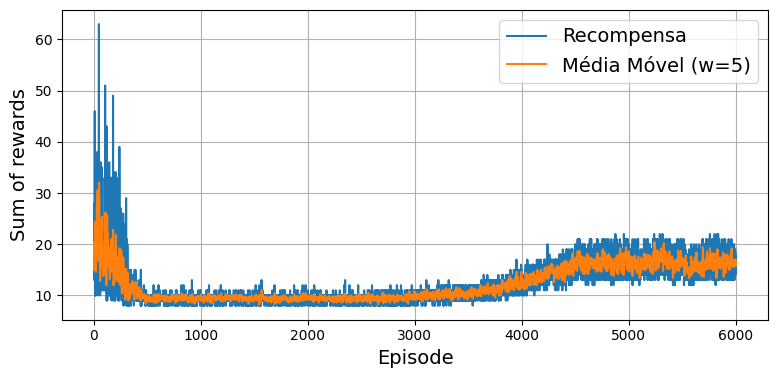

In [23]:
episodes = np.arange(1, len(rewards_history) + 1)
df = pd.DataFrame({"Episode": episodes, "Reward": rewards_history})
df["Reward_MM"] = df["Reward"].rolling(window=5, min_periods=1).mean()

plt.figure(figsize=(8, 4))
plt.plot(df["Episode"], df["Reward"], label="Recompensa")
plt.plot(df["Episode"], df["Reward_MM"], label="Média Móvel (w=5)")
plt.xlabel("Episode")
plt.ylabel("Sum of rewards")
plt.legend()
plt.grid(True)
save_fig("dqn_pytorch_rewards_plot")
plt.show()

In [24]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def show_one_episode(policy, n_max_steps=200, seed=42):
    frames = []
    env = gym.make(ENVIRONMENT, render_mode="rgb_array")
    np.random.seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        action = policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break
    env.close()
    return plot_animation(frames)

# Para exibir a animação
show_one_episode(epsilon_greedy_policy)

# Double DQN

O problema do DQN padrão é que ele usa a mesma rede (a rede alvo) para selecionar a melhor ação futura e para avaliar o valor dessa ação. Isso pode levar a uma superestimação sistemática dos valores Q, tornando o aprendizado instável.


O Double DQN corrige isso desacoplando a seleção da avaliação:

Seleção da Ação (com a Rede Principal): Primeiro, usamos a rede principal (model), que está sempre mais atualizada, para decidir qual é a melhor ação a ser tomada no próximo estado.
    Python

Código:

```py

next_actions = model(next_states_t).argmax(dim=1, keepdim=True)
```


Avaliação da Ação (com a Rede Alvo): Em vez de pegar o valor Q dessa ação da mesma rede, nós o pegamos da rede alvo (target_model), que é mais estável.
Python

código:

```py
next_q_values = target_model(next_states_t).gather(1, next_actions).squeeze(1)
```

Double DQN é uma melhoria crucial do algoritmo DQN que corrige um problema fundamental: a tendência de superestimar o valor das ações, o que pode levar a um aprendizado instável e a políticas subótimas

Essaa escolha é dada pela 

```py
target_model(next_states_t).max(1)[0]
```


O Double DQN resolve isso de forma elegante, usando as duas redes que já existem (model e target_model) com um propósito duplo, como se fossem dois cérebros:

- O Cérebro que Decide (model): Usa a rede principal, que está em constante aprendizado, para escolher qual é a melhor ação a ser tomada no próximo estado. Ela apenas aponta a direção.

- O Cérebro que Avalia (target_model): Usa a rede alvo, que é mais estável, para avaliar o valor da ação que foi escolhida pelo primeiro cérebro. Ela dá uma "segunda opinião" mais conservadora


### Vantagens do Double DQN

- Reduz a Superestimação: Leva a estimativas de valor mais realistas e confiáveis.

- Aprendizado Mais Estável: Ao reduzir as estimativas otimistas, o treinamento se torna menos propenso a oscilações.

- Melhor Desempenho Final: Frequentemente converge para políticas de melhor qualidade, resultando em maiores recompensas.

Conclusão: O Double DQN é uma mudança simples no código com um grande impacto no desempenho. É considerado o padrão hoje em dia, sendo quase sempre preferível ao DQN original por sua robustez e estabilidade.

In [25]:
def training_step(batch_size):
    states, actions, rewards, next_states, dones, _ = sample_experiences(batch_size)

    states_t = torch.FloatTensor(states).to(device)
    actions_t = torch.LongTensor(actions).to(device)
    rewards_t = torch.FloatTensor(rewards).to(device)
    next_states_t = torch.FloatTensor(next_states).to(device)
    dones_t = torch.BoolTensor(dones).to(device)

    # Q-values para as ações que foram tomadas (do modelo principal)
    q_values = model(states_t).gather(1, actions_t.unsqueeze(1)).squeeze(1)

    # --- Início da Modificação para Double DQN ---

    # 1. Usa o modelo principal (model) para selecionar a melhor ação para o próximo estado
    next_actions = model(next_states_t).argmax(dim=1, keepdim=True)
    
    # 2. Usa o modelo alvo (target_model) para avaliar o valor Q da ação selecionada
    next_q_values = target_model(next_states_t).gather(1, next_actions).squeeze(1)
    
    # --- Fim da Modificação ---
    
    # Calcula o Q-value alvo (target)
    target_q_values = rewards_t + DISCOUNT_FACTOR * next_q_values * (~dones_t)

    # Calcula a perda (loss)
    loss = loss_fn(q_values, target_q_values.detach()) # .detach() é uma boa prática aqui

    # Otimização
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


# Loop de treinamento
rewards_history = []
best_score = -np.inf

pbar = tqdm(range(N_EPISODES), desc="Eps", unit="ep")
for episode in pbar:
    obs, info = env.reset()
    total_reward = 0
    
    for step in range(MAX_STEPS):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
        total_reward += reward
        if done or truncated:
            break

    pbar.set_description(f"Episode {episode+1}/{N_EPISODES}")
    pbar.set_postfix({
        "steps": step + 1,
        "reward": f"{total_reward:.1f}",
        "eps": f"{epsilon:.3f}"
    })

    rewards_history.append(total_reward)
    if total_reward >= best_score:
        best_weights = model.state_dict()
        best_score = total_reward

    if episode > 50:
        training_step(BATCH_SIZE)
        if episode % 50 == 0:
            target_model.load_state_dict(model.state_dict())

model.load_state_dict(best_weights)

Episode 6000/6000: 100%|██████████| 6000/6000 [01:27<00:00, 68.56ep/s, steps=46, reward=46.0, eps=0.010]  


<All keys matched successfully>

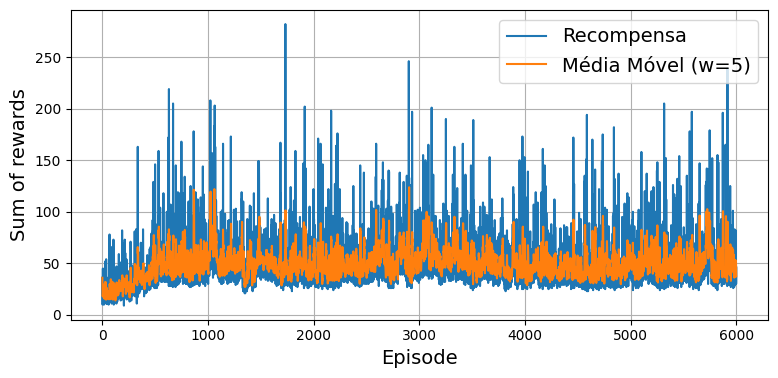

In [26]:
episodes = np.arange(1, len(rewards_history) + 1)
df = pd.DataFrame({"Episode": episodes, "Reward": rewards_history})
df["Reward_MM"] = df["Reward"].rolling(window=5, min_periods=1).mean()

plt.figure(figsize=(8, 4))
plt.plot(df["Episode"], df["Reward"], label="Recompensa")
plt.plot(df["Episode"], df["Reward_MM"], label="Média Móvel (w=5)")
plt.xlabel("Episode")
plt.ylabel("Sum of rewards")
plt.legend()
plt.grid(True)
save_fig("dqn_pytorch_rewards_plot")
plt.show()

In [27]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def show_one_episode(policy, n_max_steps=200, seed=42):
    frames = []
    env = gym.make(ENVIRONMENT, render_mode="rgb_array")
    np.random.seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        action = policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break
    env.close()
    return plot_animation(frames)

# Para exibir a animação
show_one_episode(epsilon_greedy_policy)

# Tarefa

Compare o DQN (rede principal e alvo) e Double DQN nos os seguintes ambientes do [Classic Control](https://gymnasium.farama.org/environments/classic_control/) (fazendo as devidas modificações no código do experimento onde necessário):

 - [Acrobot](https://gymnasium.farama.org/environments/classic_control/acrobot/)

- [Mountain Car](https://gymnasium.farama.org/environments/classic_control/acrobot/)

Para cada ambiente mostre o gráfico do retorno por episódios, indique qual método obteve os melhores resultados e liste os hiperparâmetros utilizados (a arquitetura da rede neural também pode ser modificada). 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from collections import deque
from pathlib import Path


class DQN(nn.Module):
    def __init__(self, input_shape, n_outputs):
        super(DQN, self).__init__()
        # Arquitetura flexível - pode ser ajustada nos hiperparâmetros
        self.fc1 = nn.Linear(input_shape[0], 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, n_outputs)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


def run_experiment(env_name, method, hyperparams, seed=42):
    """
    Roda um experimento de treinamento completo para DQN ou Double DQN.

    Args:
        env_name (str): Nome do ambiente do Gymnasium (ex: "Acrobot-v1").
        method (str): Método a ser usado ("DQN" ou "DoubleDQN").
        hyperparams (dict): Dicionário contendo todos os hiperparâmetros.
        seed (int): Semente para reprodutibilidade.

    Returns:
        list: Histórico de recompensas por episódio.
    """
    # --- 1. Inicialização ---
    env = gym.make(env_name)
    torch.manual_seed(seed)
    np.random.seed(seed)
    env.reset(seed=seed)

    # Extrair hiperparâmetros
    N_EPISODES = hyperparams["N_EPISODES"]
    MAX_STEPS = hyperparams["MAX_STEPS"]
    BATCH_SIZE = hyperparams["BATCH_SIZE"]
    DISCOUNT_FACTOR = hyperparams["DISCOUNT_FACTOR"]
    LEARNING_RATE = hyperparams["LEARNING_RATE"]
    REPLAY_BUFFER_SIZE = hyperparams["REPLAY_BUFFER_SIZE"]
    UPDATE_TARGET_EVERY = hyperparams["UPDATE_TARGET_EVERY"]
    EPSILON_DECAY_RATE = hyperparams["EPSILON_DECAY_RATE"]
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    input_shape = env.observation_space.shape
    n_outputs = env.action_space.n

    model = DQN(input_shape, n_outputs).to(device)
    target_model = DQN(input_shape, n_outputs).to(device)
    target_model.load_state_dict(model.state_dict())
    target_model.eval()

    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    loss_fn = nn.MSELoss()
    
    replay_buffer = deque(maxlen=REPLAY_BUFFER_SIZE)
    rewards_history = []
    
    # --- 2. Funções Auxiliares ---
    def epsilon_greedy_policy(state, epsilon=0):
        if np.random.rand() < epsilon:
            return np.random.randint(n_outputs)
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            with torch.no_grad():
                q_values = model(state_tensor)
            return q_values.argmax().item()

    def sample_experiences(batch_size):
        indices = np.random.randint(len(replay_buffer), size=batch_size)
        batch = [replay_buffer[index] for index in indices]
        states, actions, rewards, next_states, dones, truncateds = zip(*batch)
        return (np.array(states), np.array(actions), np.array(rewards, dtype=np.float32),
                np.array(next_states), np.array(dones), np.array(truncateds))

    def play_one_step(env, state, epsilon):
        action = epsilon_greedy_policy(state, epsilon)
        next_state, reward, done, truncated, info = env.step(action)
        replay_buffer.append((state, action, reward, next_state, done, truncated))
        return next_state, reward, done, truncated, info

    def training_step(batch_size):
        states, actions, rewards, next_states, dones, _ = sample_experiences(batch_size)
        
        states_t = torch.FloatTensor(states).to(device)
        actions_t = torch.LongTensor(actions).to(device)
        rewards_t = torch.FloatTensor(rewards).to(device)
        next_states_t = torch.FloatTensor(next_states).to(device)
        dones_t = torch.BoolTensor(dones).to(device)

        q_values = model(states_t).gather(1, actions_t.unsqueeze(1)).squeeze(1)

        if method == "DQN":
            next_q_values = target_model(next_states_t).max(1)[0]
        elif method == "DoubleDQN":
            next_actions = model(next_states_t).argmax(dim=1, keepdim=True)
            next_q_values = target_model(next_states_t).gather(1, next_actions).squeeze(1)
        
        target_q_values = rewards_t + DISCOUNT_FACTOR * next_q_values * (~dones_t)
        loss = loss_fn(q_values, target_q_values.detach())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # --- 3. Loop de Treinamento ---
    pbar = tqdm(range(N_EPISODES), desc=f"Treinando {method} em {env_name}")
    for episode in pbar:
        obs, info = env.reset()
        total_reward = 0
        
        for step in range(MAX_STEPS):
            epsilon = max(1 - episode / EPSILON_DECAY_RATE, 0.01)
            obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
            total_reward += reward
            if done or truncated:
                break
        
        rewards_history.append(total_reward)
        pbar.set_postfix({"reward": f"{total_reward:.1f}", "eps": f"{epsilon:.3f}"})

        if len(replay_buffer) > BATCH_SIZE:
            training_step(BATCH_SIZE)
            if (episode + 1) % UPDATE_TARGET_EVERY == 0:
                target_model.load_state_dict(model.state_dict())
    
    env.close()
    return rewards_history

# --- Função para Plotar os Resultados ---
def plot_results(dqn_rewards, ddqn_rewards, env_name, window=100):
    """Plota os resultados da comparação."""
    plt.figure(figsize=(12, 6))
    
    # Prepara os dados para plotagem com média móvel
    df_dqn = pd.DataFrame({'Reward': dqn_rewards})
    df_ddqn = pd.DataFrame({'Reward': ddqn_rewards})
    
    df_dqn['Moving_Avg'] = df_dqn['Reward'].rolling(window=window).mean()
    df_ddqn['Moving_Avg'] = df_ddqn['Reward'].rolling(window=window).mean()
    
    # Plota as médias móveis
    plt.plot(df_dqn.index, df_dqn['Moving_Avg'], label=f'DQN (Média Móvel w={window})', color='blue')
    plt.plot(df_ddqn.index, df_ddqn['Moving_Avg'], label=f'Double DQN (Média Móvel w={window})', color='red')
    
    # Plota as recompensas brutas (com transparência)
    plt.plot(df_dqn.index, df_dqn['Reward'], label='DQN (Recompensa Bruta)', color='lightblue', alpha=0.3)
    plt.plot(df_ddqn.index, df_ddqn['Reward'], label='Double DQN (Recompensa Bruta)', color='salmon', alpha=0.3)
    
    plt.xlabel("Episódio")
    plt.ylabel("Recompensa Total")
    plt.title(f'Comparação DQN vs. Double DQN no Ambiente: {env_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

/home/rafael/anaconda3/envs/figas2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Treinando DoubleDQN em MountainCar-v0: 100%|██████████| 2000/2000 [01:14<00:00, 26.72it/s, reward=-200.0, eps=0.010]


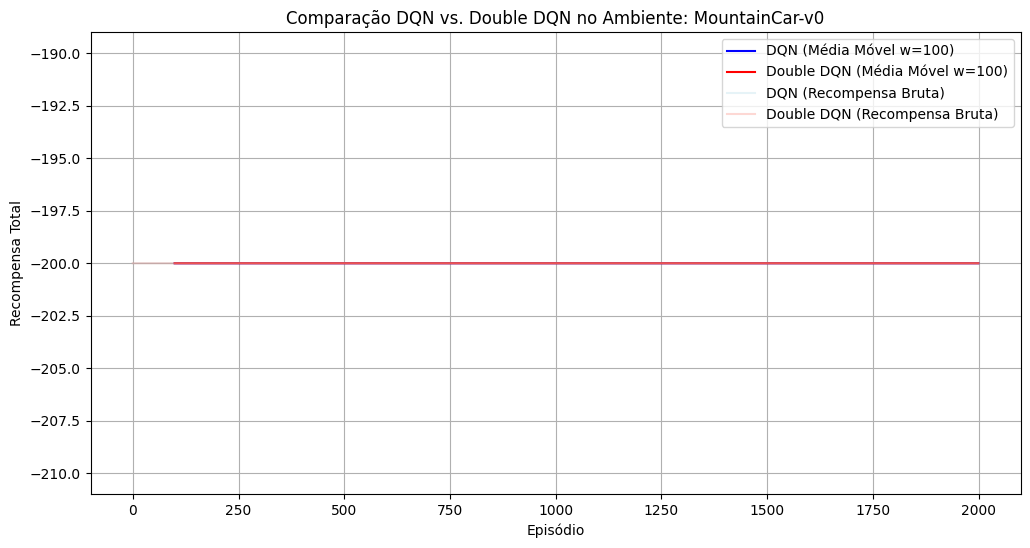

In [2]:
mountain_car_params = {
    "N_EPISODES": 2000,
    "MAX_STEPS": 500, 
    "BATCH_SIZE": 32,
    "DISCOUNT_FACTOR": 0.99,
    "LEARNING_RATE": 1e-3,
    "REPLAY_BUFFER_SIZE": 10000,
    "UPDATE_TARGET_EVERY": 10,
    "EPSILON_DECAY_RATE": 1000 # Decaimento mais lento do epsilon
}

# --- Rodar os experimentos ---
mc_dqn_rewards = run_experiment("MountainCar-v0", "DQN", mountain_car_params)
mc_ddqn_rewards = run_experiment("MountainCar-v0", "DoubleDQN", mountain_car_params)

# --- Plotar os resultados ---
plot_results(mc_dqn_rewards, mc_ddqn_rewards, "MountainCar-v0", window=100)

In [ ]:
# --- Hiperparâmetros para o Acrobot-v1 ---
acrobot_params = {
    "N_EPISODES": 1000,
    "MAX_STEPS": 500, # Padrão do ambiente
    "BATCH_SIZE": 64,
    "DISCOUNT_FACTOR": 0.99,
    "LEARNING_RATE": 5e-4,
    "REPLAY_BUFFER_SIZE": 20000,
    "UPDATE_TARGET_EVERY": 10,
    "EPSILON_DECAY_RATE": 500
}

# --- Rodar os experimentos ---
acrobot_dqn_rewards = run_experiment("Acrobot-v1", "DQN", acrobot_params)
acrobot_ddqn_rewards = run_experiment("Acrobot-v1", "DoubleDQN", acrobot_params)

# --- Plotar os resultados ---
plot_results(acrobot_dqn_rewards, acrobot_ddqn_rewards, "Acrobot-v1", window=50)

Treinando DoubleDQN em Acrobot-v1:  36%|███▋      | 365/1000 [00:28<01:15,  8.38it/s, reward=-500.0, eps=0.272]